<a href="https://colab.research.google.com/github/karthik1636/karthik.github.io/blob/main/Transformer_Tweets_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 14 19:15:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1, L2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
df = pd.read_csv('emotion_dataset.csv')
df = df.drop_duplicates()
df = df.dropna()
df.head()


,text,Emotion
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save 50 rest go ...,0
3,whole body feels itchy like fire,0
4,behaving mad see,0


In [17]:
df

,text,Emotion
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many times ball managed save 50 rest go ...,0
3,whole body feels itchy like fire,0
4,behaving mad see,0
...,...,...
1599995,woke school best feeling ever,4
1599996,thewdb com cool hear old walt interviews,4
1599997,ready mojo makeover ask details,4
1599998,happy 38th birthday boo alll time tupac amaru ...,4


In [19]:
def safe_lower(input_text):
    if pd.isnull(input_text):
        return None  # Choose how to handle nulls based on your context
    return str(input_text).lower()

df['text'] = df['text'].apply(safe_lower)


In [20]:
print(f"Unique emotions: {df['Emotion'].unique()}\n Number of unique emotions: {df['Emotion'].nunique()}")

Unique emotions: [0 4]
 Number of unique emotions: 2


We need to convert our labels into numeric values so the model can work with them

In [21]:
df['Label'], Emotions = pd.factorize(df['Emotion'])

In [22]:
X = df['text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

Before we can feed our inputs into the model, we need to convert them into a form the computer can read: numbers. Tensorflow has a tokenizer method built in, which essentially creates a dictionary of words from a series of texts.

Once we have all of our tokens, we can transform our lines of text into sequences of tokens which can be fed into the model.

In [23]:
tokenizer = Tokenizer(num_words = 60000, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

Our model expects a uniform input size. To accomplish this we pad the sequences with 0's so that each input is equal in size to our largest input.

In [24]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

Maximum sequence length (maxlen): 50


In [25]:
np.max(X_train_padded) + 1

60000

In [26]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=178, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [27]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [28]:
model = Sequential()
model.add(Input(shape=(maxlen,),dtype='float64'))
model.add(PositionalEmbedding(vocab_size = np.max(X_train_padded) + 1, d_model = 100))
model.add(TransformerBlock(embed_dim = 100, num_heads = 2, ff_dim = 64))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',
                kernel_regularizer=L1(0.01),
                activity_regularizer=L2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

In [29]:
# Now compile and summarize your model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posi  (None, 50, 100)           6000000   
 tionalEmbedding)                                                
                                                                 
 transformer_block (Transfo  (None, 50, 100)           94064     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                        

In [30]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test_padded, y_test))

Epoch 1/5
37243/37243 [==============================] - 353s 9ms/step - loss: 0.6001 - accuracy: 0.7530 - val_loss: 0.5247 - val_accuracy: 0.7710
Epoch 2/5
37243/37243 [==============================] - 329s 9ms/step - loss: 0.5323 - accuracy: 0.7787 - val_loss: 0.5243 - val_accuracy: 0.7713
Epoch 3/5
37243/37243 [==============================] - 316s 8ms/step - loss: 0.5215 - accuracy: 0.7832 - val_loss: 0.5172 - val_accuracy: 0.7740
Epoch 4/5
37243/37243 [==============================] - 318s 9ms/step - loss: 0.5176 - accuracy: 0.7842 - val_loss: 0.5148 - val_accuracy: 0.7719
Epoch 5/5
37243/37243 [==============================] - 322s 9ms/step - loss: 0.5163 - accuracy: 0.7813 - val_loss: 0.5122 - val_accuracy: 0.7712


In [31]:
history_dict = history.history
json.dump(history_dict, open('transformer_history','w'))

In [32]:
model.save('Transformer_Model')

In [33]:
model = tf.keras.models.load_model("Transformer_Model")

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posi  (None, 50, 100)           6000000   
 tionalEmbedding)                                                
                                                                 
 transformer_block (Transfo  (None, 50, 100)           94064     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                        

In [36]:
history = json.load(open("transformer_history",'r'))

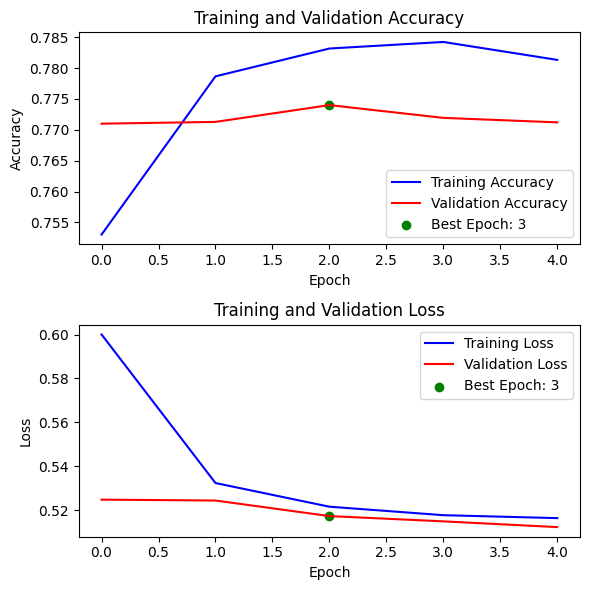

In [37]:
best_epoch = history['val_accuracy'].index(max(history['val_accuracy'])) + 1

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training and validation accuracy
axs[0].plot(history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history['loss'], label='Training Loss', color='blue')
axs[1].plot(history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [38]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

9311/9311 [==============================] - 26s 3ms/step


In [40]:
print(classification_report(y_test,y_pred,labels = list(np.arange(2)),target_names = ['0', '4'], zero_division = 0.0))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78    149835
           4       0.78      0.75      0.76    148108

    accuracy                           0.77    297943
   macro avg       0.77      0.77      0.77    297943
weighted avg       0.77      0.77      0.77    297943



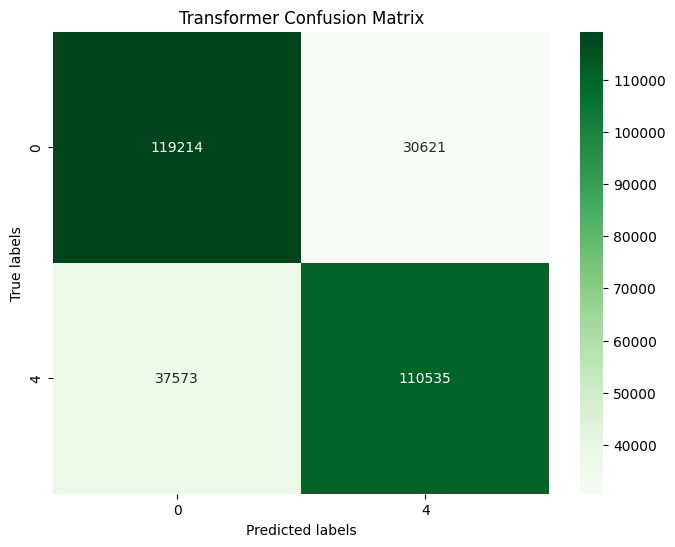

In [41]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt='d', cmap = 'Greens',
           xticklabels = ['0', '4'],
           yticklabels = ['0', '4'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Transformer Confusion Matrix')
plt.show()

### Generative Model

In [ ]:
songs = pd.read_csv(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\Song Data\lyrics-data.csv")
songs_en = songs[songs.language == 'en']
songs_en = songs_en[:250]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(songs_en['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(songs_en['Lyric'].astype(str))
tokenized_sentences[0]

[2,
 63,
 22,
 2952,
 149,
 2,
 62,
 15,
 318,
 7,
 868,
 1,
 5,
 3,
 228,
 264,
 149,
 3,
 479,
 2953,
 208,
 12,
 15,
 165,
 1326,
 5,
 133,
 9,
 2954,
 1327,
 7,
 18,
 480,
 1007,
 2955,
 10,
 53,
 124,
 228,
 200,
 1520,
 614,
 107,
 35,
 29,
 1008,
 517,
 36,
 438,
 5,
 680,
 2,
 27,
 40,
 61,
 9,
 467,
 1328,
 681,
 201,
 153,
 5,
 1329,
 9,
 417,
 7,
 615,
 3,
 939,
 14,
 112,
 76,
 869,
 22,
 10,
 53,
 124,
 228,
 200,
 3,
 65,
 2,
 1330,
 31,
 1,
 55,
 38,
 53,
 2956,
 3,
 2957,
 2958,
 26,
 9,
 84,
 417,
 5,
 3,
 157,
 7,
 133,
 2959,
 30,
 382,
 219,
 29,
 1331,
 12,
 3,
 518,
 368,
 30,
 18,
 151,
 158,
 10,
 53,
 124,
 228,
 200,
 1520,
 614,
 107,
 35,
 29,
 1008,
 517,
 36,
 438,
 5,
 680,
 2,
 27,
 40,
 61,
 9,
 467,
 1328,
 681,
 201,
 153,
 5,
 1329,
 9,
 417,
 7,
 615,
 23,
 939,
 14,
 112,
 76,
 869,
 22,
 10,
 53,
 124,
 228,
 200,
 3,
 65,
 2,
 1330,
 31,
 1,
 53,
 202,
 15,
 11,
 88,
 3,
 479,
 519,
 22,
 940,
 2,
 409,
 14,
 24,
 126,
 285,
 23,
 2240,
 520,
 36

In [ ]:
# Create n-gram sequences
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)

# Pre-padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# Creating predictors and labels
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100,input_length=max_sequence_len - 1))
model.add(TransformerBlock(embed_dim = 100, num_heads = 2, ff_dim = 64))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
    metrics=['accuracy']
    )
earlystop = EarlyStopping(monitor='loss', min_delta = 0, patience = 3, verbose = 0, mode='auto')

In [ ]:
history = model.fit(X,y, epochs = 10, verbose = 1, callbacks = [earlystop])

Epoch 1/10
2972/2972 [==============================] - 310s 103ms/step - loss: 6.2141 - accuracy: 0.0473
Epoch 2/10
2972/2972 [==============================] - 308s 104ms/step - loss: 5.8552 - accuracy: 0.0564
Epoch 3/10
2972/2972 [==============================] - 308s 104ms/step - loss: 5.6226 - accuracy: 0.0631
Epoch 4/10
2972/2972 [==============================] - 305s 103ms/step - loss: 5.4442 - accuracy: 0.0676
Epoch 5/10
2972/2972 [==============================] - 304s 102ms/step - loss: 5.3066 - accuracy: 0.0692
Epoch 6/10
2972/2972 [==============================] - 303s 102ms/step - loss: 5.1944 - accuracy: 0.0734
Epoch 7/10
2972/2972 [==============================] - 306s 103ms/step - loss: 5.0997 - accuracy: 0.0745
Epoch 8/10
2972/2972 [==============================] - 304s 102ms/step - loss: 5.0244 - accuracy: 0.0761
Epoch 9/10
2972/2972 [==============================] - 309s 104ms/step - loss: 4.9555 - accuracy: 0.0777
Epoch 10/10
2972/2972 [=======================

In [ ]:
def generate_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)
        choice = np.random.choice([1,2,3])
        # sort ascending and select from 3 highest probabilities
        predicted = np.argsort(predictions)[0][-choice]

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [ ]:
def generate_lyrics(seed_text, next_words):
    # Loop until desired length is reached
    for _ in range(next_words):

	# Convert the seed text to a token sequence
    	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
    	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
    	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
    	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
    	if predicted != 0:

		# Look up the word associated with the index.
    		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
    		seed_text += " " + output_word

# Print the result
    print(seed_text)

In [ ]:
seed_text = "hello darkness my old friend"
generate_lyrics(seed_text, 10)

hello darkness my old friend the the the the the the the the the the
